In [3]:
## Import Libraries in this block ##
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path = 'DeepLearning'
sys_path = os.path.join(prefix, customized_path)
sys.path.append(sys_path)
%cd /content/gdrive/MyDrive/DeepLearning
!ls

/content/gdrive/MyDrive/DeepLearning
best_model_c10.h5  cat.png  cnn-y-network.png


In [7]:
## Funtion to load and normalize data

def load_datset(dataset):
  if dataset == "cifar10":
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
  elif dataset == "cifar100":
    cifar100 = tf.keras.datasets.cifar100
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

  
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  print("Train Data shape for {}:{}{}".format(dataset,x_train.shape, y_train.shape))
  print("Test Data shape for {}:{}{}".format(dataset,x_test.shape, y_test.shape))

  return x_train, x_test,y_train,y_test


In [6]:
def build_y_net(input_shape,dropout,n_filters,n_layers, num_labels):
  ## Left branch of Y network
  left_inputs = Input(shape=input_shape)
  x = left_inputs
  filters = n_filters

  # 3 layers of Conv2D-Dropout-MaxPooling2D
  # number of filters doubles after each layer (32-64-128)
  for i in range(n_layers):
      x = Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu')(x)
      x = Dropout(dropout)(x)
      x = MaxPooling2D(pool_size=(2,2))(x)
      filters *= 2

  ## Right branch of Y network
  right_inputs = Input(shape=input_shape)
  y = right_inputs
  filters = n_filters
  # Layers of Conv2D-Dropout-MaxPooling2D
  # Number of filters doubles after each layer (32-64-128)
  for i in range(n_layers):
      y = Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 padding='same',
                 activation='relu',
                 dilation_rate=2)(y)
      y = Dropout(dropout)(y)
      y = MaxPooling2D(pool_size=(2,2))(y)
      filters *= 2

  # Merge left and right branches outputs
  y = concatenate([x, y])
  # Feature maps to vector before connecting to Dense 
  y = Flatten()(y)
  y = Dropout(dropout)(y)
  outputs = Dense(num_labels, activation='softmax')(y)

  # Build the model (functional API)
  model = Model([left_inputs, right_inputs], outputs)
  
  return model

In [7]:

def train_test_plot(model, x_train,y_train,x_val,y_val,x_test,y_test, optimizer,epochs,batch_size):
  
  
  # Compile model
  model.compile(loss= 'categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  #augmented data
  width_shift = 0.15
  height_shift = 0.15
  flip = True

  datagen = ImageDataGenerator(
      featurewise_center=True,
      rotation_range=10,
      horizontal_flip=flip,
      width_shift_range=width_shift,
      height_shift_range=height_shift,
      )
  datagen.fit(x_train)
  # Train the model 
  history=model.fit(datagen.flow([x_train,x_train], y_train, batch_size=batch_size),
          steps_per_epoch=len(x_train) / batch_size, epochs=epochs,validation_data= ([x_val,x_val],y_val))

  
  # Evaluate Model on Test set
  score = model.evaluate([x_test, x_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=2)
  print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
  
  #Plot training curve
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [8]:
#Load both datasets
#CIFAR10 
x_train, x_test,y_train,y_test = load_datset("cifar10")
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# From sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Number of unique classes:",num_labels)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)

#CIFAR100
x_train_100, x_test_100,y_train_100,y_test_100 = load_datset("cifar100")

num_labels_100 = len(np.unique(y_train_100))
y_train_100 = to_categorical(y_train_100)
y_test_100 = to_categorical(y_test_100)
print("Number of unique classes:",num_labels_100)

x_train_100, x_val_100, y_train_100, y_val_100 = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)


170500096/170498071 [==============================] - 2s 0us/step
Train Data shape for cifar10:(50000, 32, 32, 3)(50000, 1)
Test Data shape for cifar10:(10000, 32, 32, 3)(10000, 1)
Number of unique classes: 10
169009152/169001437 [==============================] - 2s 0us/step
Train Data shape for cifar100:(50000, 32, 32, 3)(50000, 1)
Test Data shape for cifar100:(10000, 32, 32, 3)(10000, 1)
Number of unique classes: 100


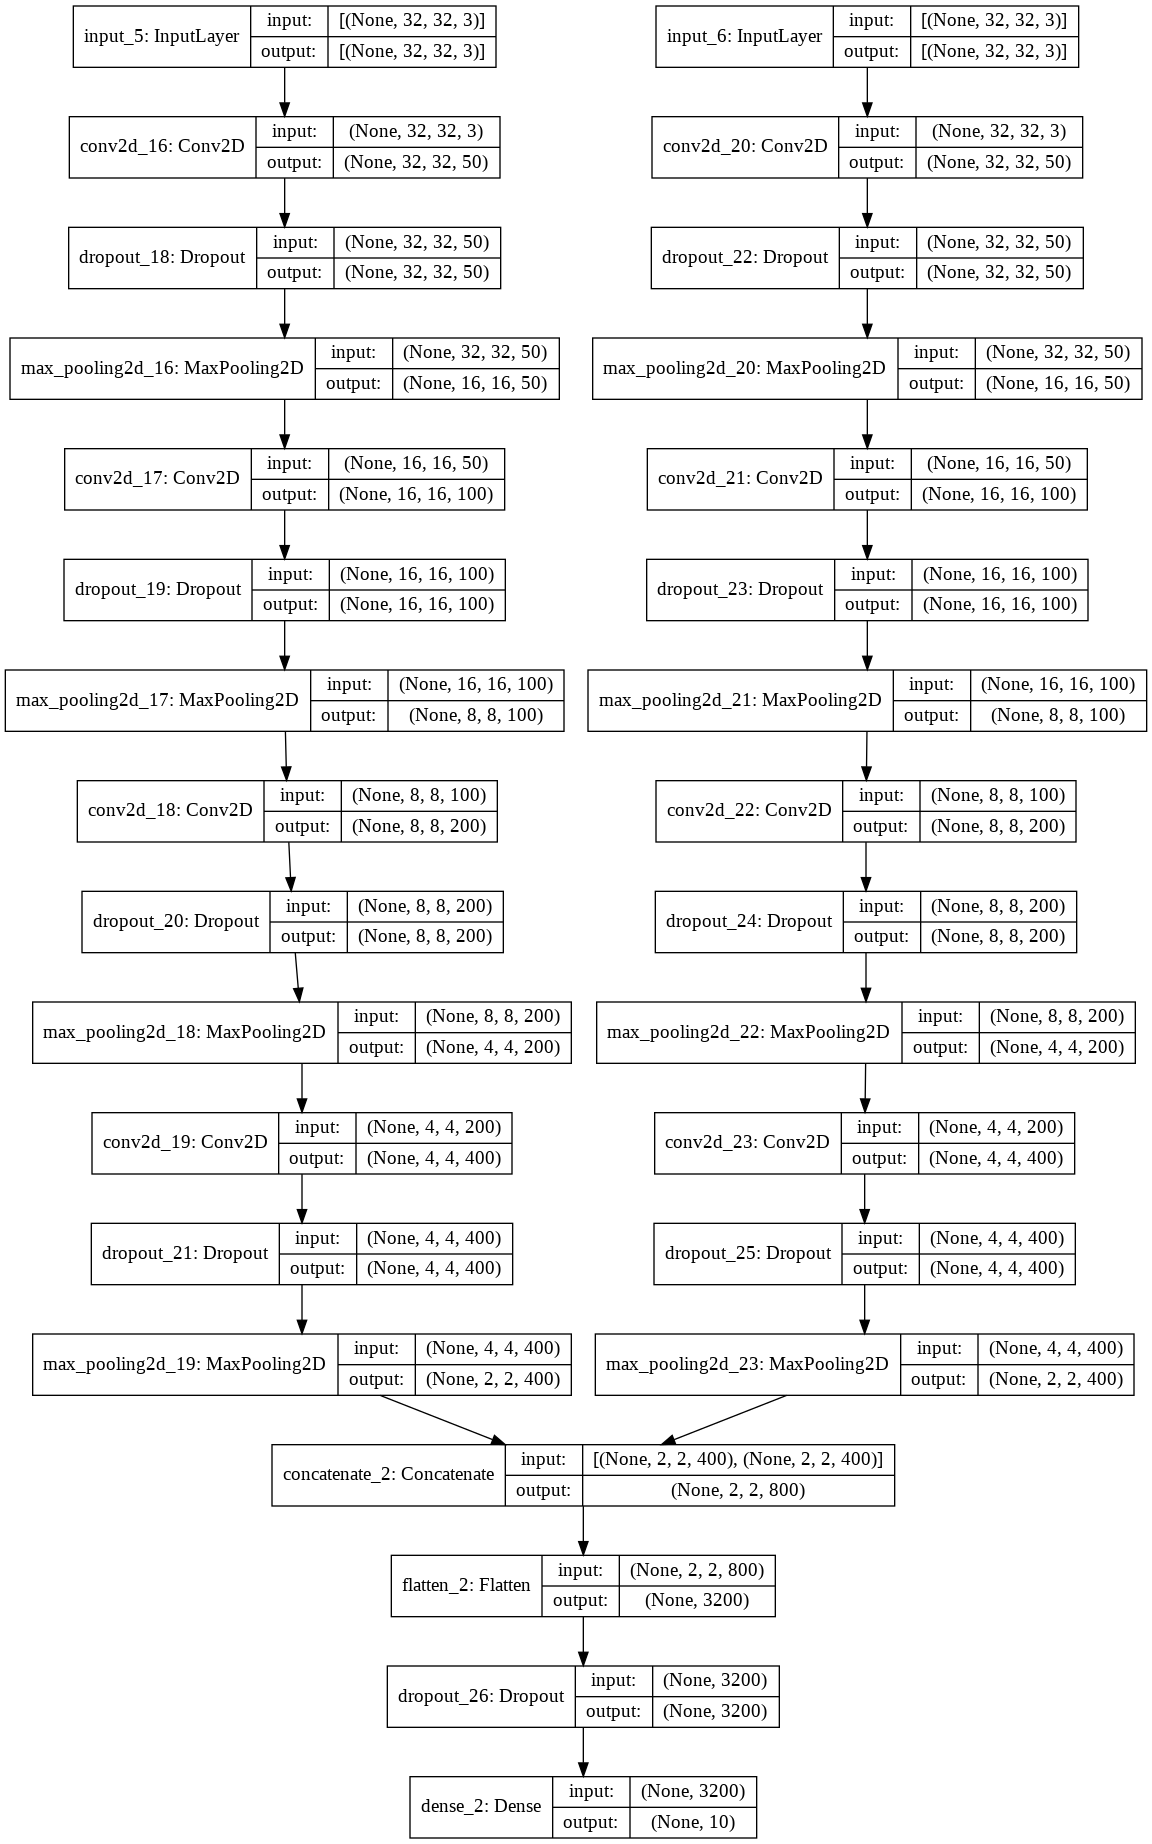

In [12]:
#Cifar10
## Network parameters
batch_size = 500
kernel_size = (3,3)
dropout = 0.3
n_filters =50
n_layers = 4

model=build_y_net(input_shape,dropout,n_filters,n_layers,num_labels)

# verify the model using graph
# enable this if pydot can be installed
#!pip install pydot
plot_model(model, to_file='cnn-y-network.png', show_shapes=True)


# verify the model using layer text description
#model.summary()



In [ ]:
##use if you have saved model(remeber to change path in earlier sections to point to the saved model)
##Load saved model and check accuracy
!ls
model = tf.keras.models.load_model('best_model_c10.h5')
#new_model.summary()
loss, acc = model.evaluate([x_test,x_test], y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

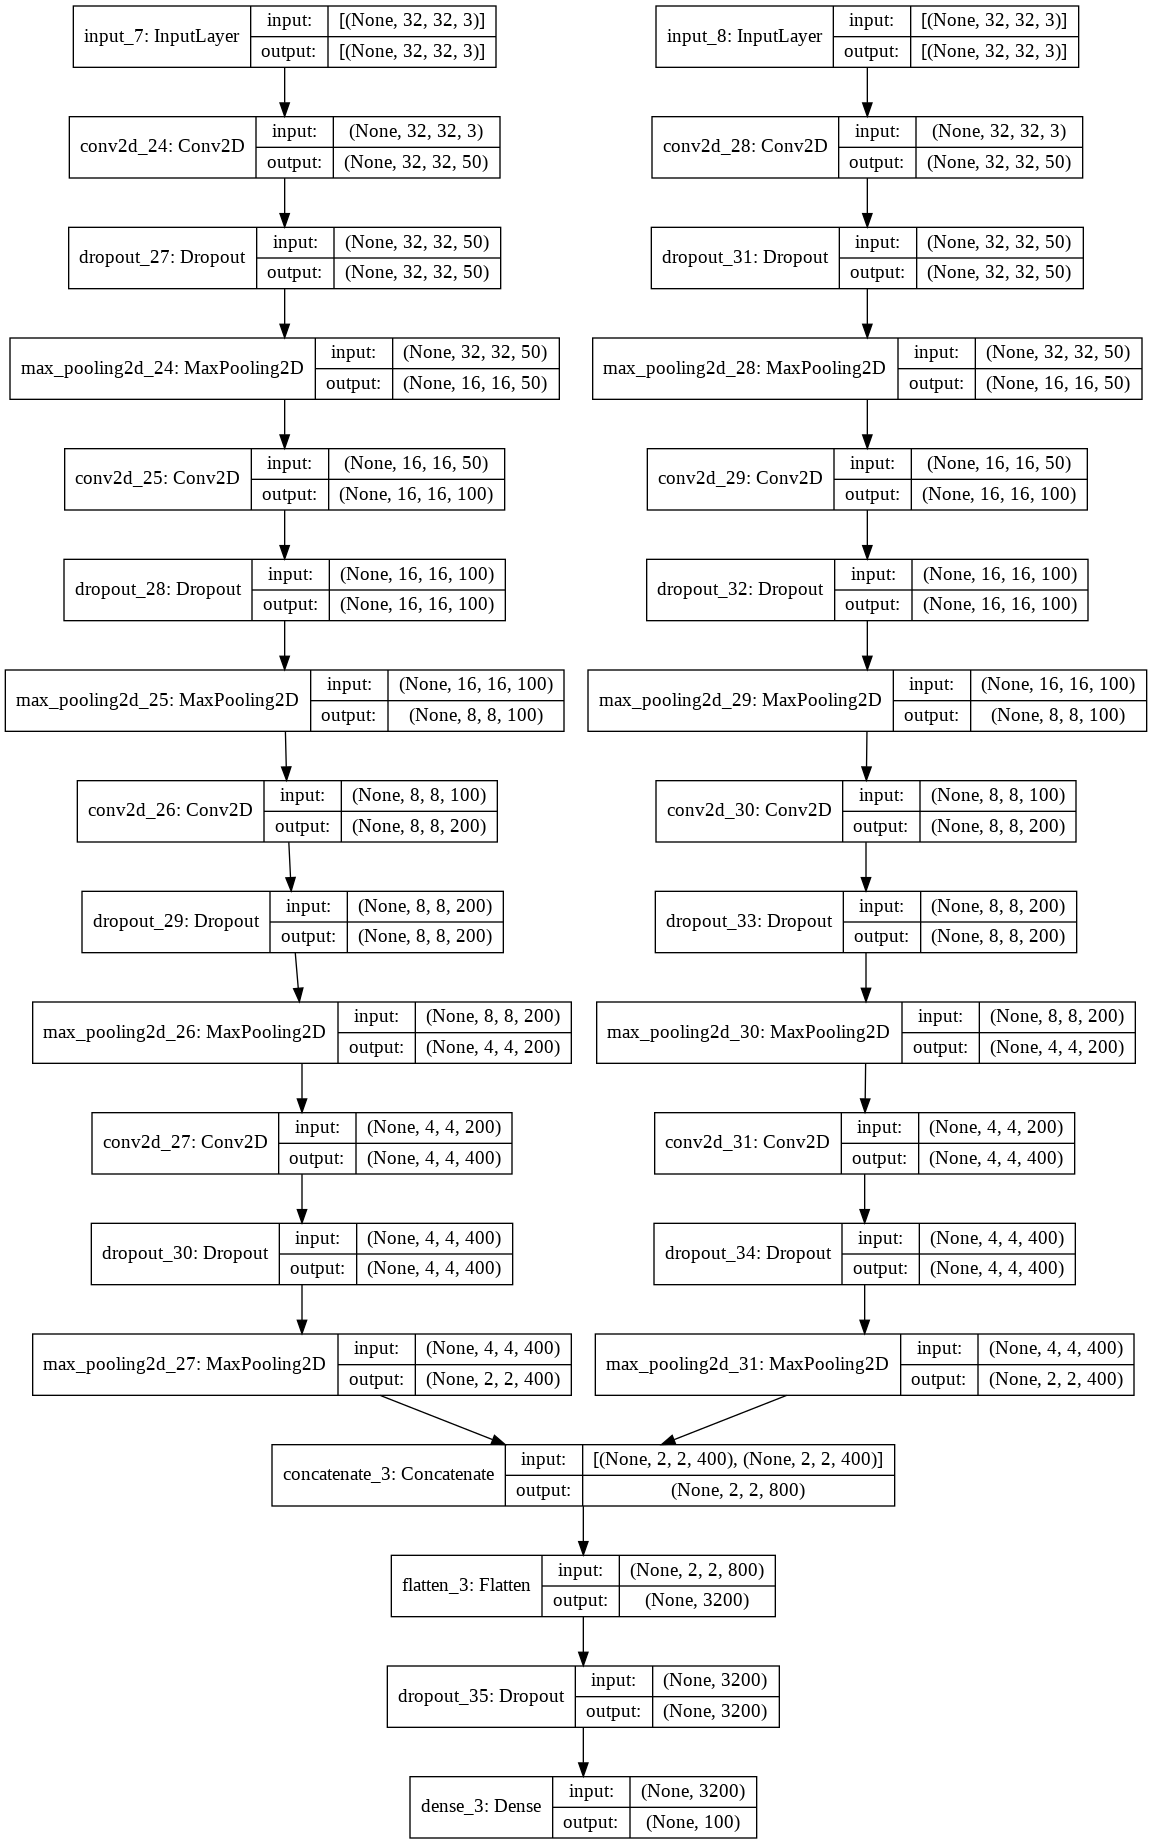

In [ ]:
#Cifar100
## Network parameters
input_shape = (x_train_100.shape[1], x_train_100.shape[2], x_train_100.shape[3])
batch_size = 500
kernel_size = (3,3)
dropout = 0.3
n_filters =50
n_layers = 4

model_100 = build_y_net(input_shape,dropout,n_filters,n_layers,num_labels_100)

# verify the model using graph
# enable this if pydot can be installed
#!pip install pydot
plot_model(model_100, to_file='cnn-y-network.png', show_shapes=True)


# verify the model using layer text description
#model.summary()

Epoch 1/100
80/80 [==============================] - 13s 150ms/step - loss: 4.3743 - accuracy: 0.0400 - val_loss: 4.0338 - val_accuracy: 0.1515
Epoch 2/100
80/80 [==============================] - 12s 148ms/step - loss: 3.5137 - accuracy: 0.1702 - val_loss: 3.7614 - val_accuracy: 0.2069
Epoch 3/100
80/80 [==============================] - 12s 149ms/step - loss: 3.0999 - accuracy: 0.2426 - val_loss: 3.5730 - val_accuracy: 0.2439
Epoch 4/100
80/80 [==============================] - 12s 148ms/step - loss: 2.8335 - accuracy: 0.2921 - val_loss: 3.4040 - val_accuracy: 0.2765
Epoch 5/100
80/80 [==============================] - 12s 146ms/step - loss: 2.6035 - accuracy: 0.3400 - val_loss: 3.2137 - val_accuracy: 0.3259
Epoch 6/100
80/80 [==============================] - 12s 145ms/step - loss: 2.4556 - accuracy: 0.3708 - val_loss: 3.2549 - val_accuracy: 0.2931
Epoch 7/100
80/80 [==============================] - 12s 145ms/step - loss: 2.3027 - accuracy: 0.4021 - val_loss: 3.0333 - val_accuracy:

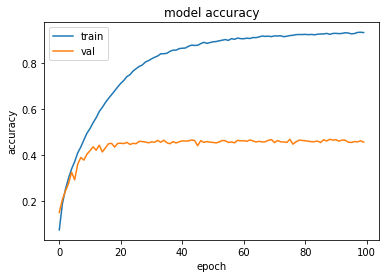

In [ ]:
##CIFAR100
## Training parameters
optimizer = "adam"
epochs = 100

train_test_plot(model_100,x_train_100,y_train_100,x_val_100,y_val_100,x_test_100,y_test_100,optimizer,epochs)
model.save('best_model_c100.h5')

Epoch 1/200
80/80 [==============================] - 48s 146ms/step - loss: 1.9912 - accuracy: 0.2714 - val_loss: 1.8298 - val_accuracy: 0.4329
Epoch 2/200
80/80 [==============================] - 11s 140ms/step - loss: 1.4451 - accuracy: 0.4754 - val_loss: 1.6180 - val_accuracy: 0.5476
Epoch 3/200
80/80 [==============================] - 11s 142ms/step - loss: 1.2322 - accuracy: 0.5606 - val_loss: 1.4799 - val_accuracy: 0.5860
Epoch 4/200
80/80 [==============================] - 11s 143ms/step - loss: 1.0890 - accuracy: 0.6113 - val_loss: 1.3400 - val_accuracy: 0.6386
Epoch 5/200
80/80 [==============================] - 12s 144ms/step - loss: 0.9763 - accuracy: 0.6579 - val_loss: 1.2716 - val_accuracy: 0.6533
Epoch 6/200
80/80 [==============================] - 12s 146ms/step - loss: 0.8931 - accuracy: 0.6861 - val_loss: 1.1823 - val_accuracy: 0.6726
Epoch 7/200
80/80 [==============================] - 12s 148ms/step - loss: 0.8247 - accuracy: 0.7097 - val_loss: 1.1358 - val_accuracy:

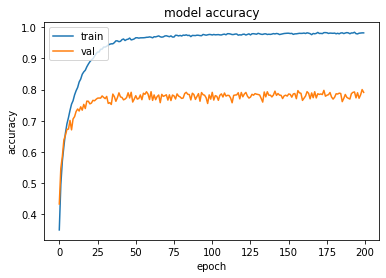

In [ ]:
## CIFAR10
## Training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 200

train_test_plot(model,x_train,y_train,x_val,y_val,x_test,y_test,optimizer,epochs)

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

2 conv2d_8 (None, 32, 32, 50)
3 conv2d_12 (None, 32, 32, 50)
8 conv2d_9 (None, 16, 16, 100)
9 conv2d_13 (None, 16, 16, 100)
14 conv2d_10 (None, 8, 8, 200)
15 conv2d_14 (None, 8, 8, 200)
20 conv2d_11 (None, 4, 4, 400)
21 conv2d_15 (None, 4, 4, 400)


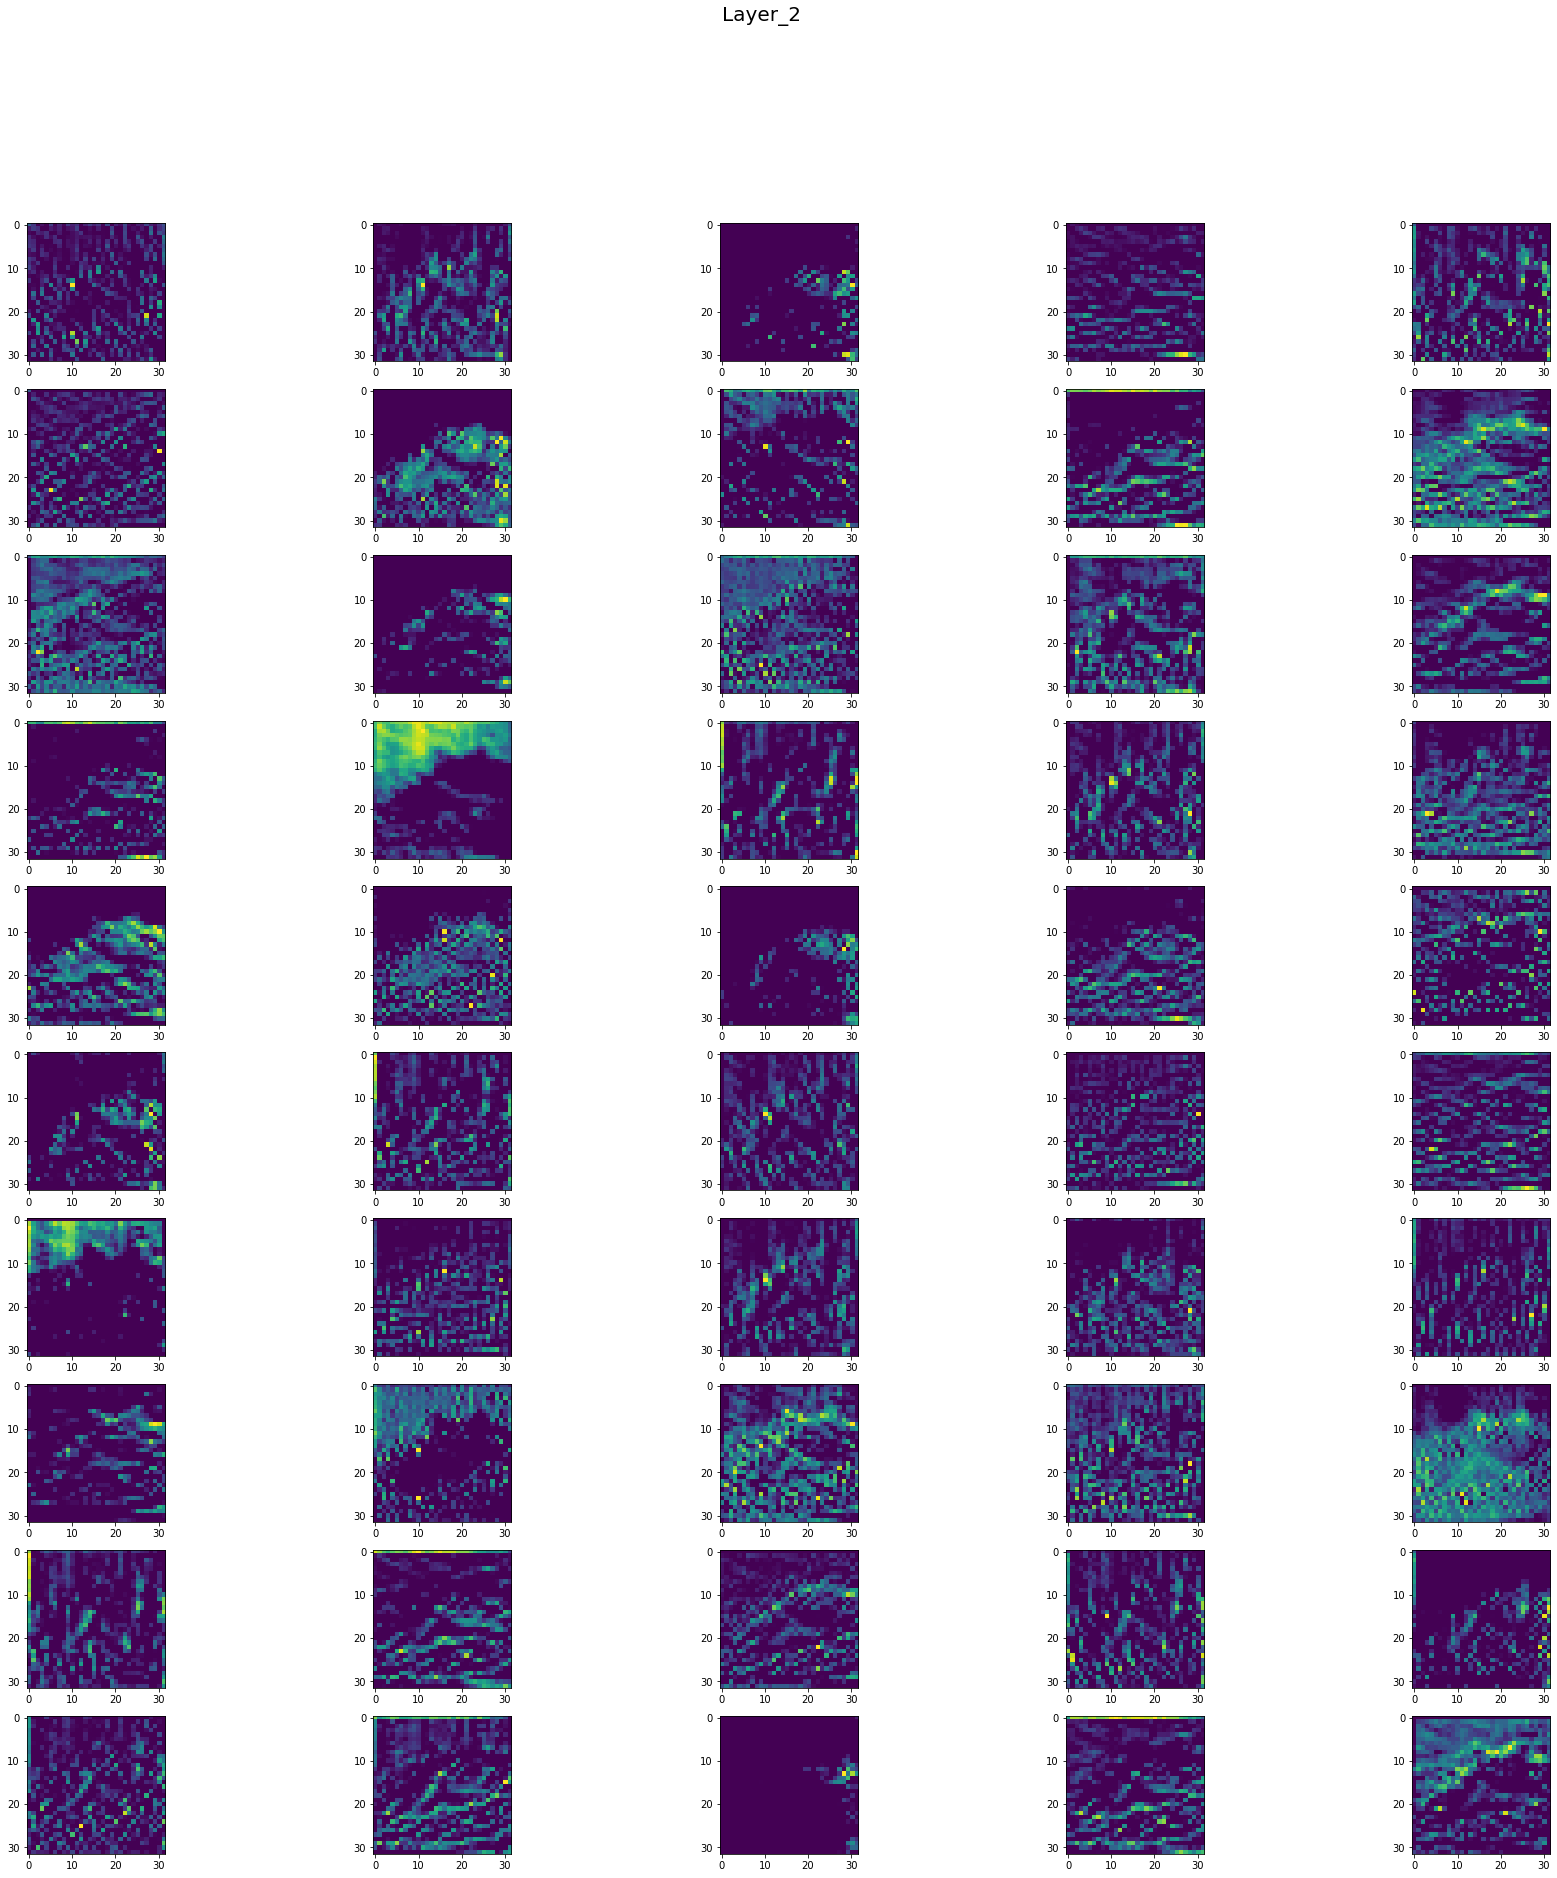

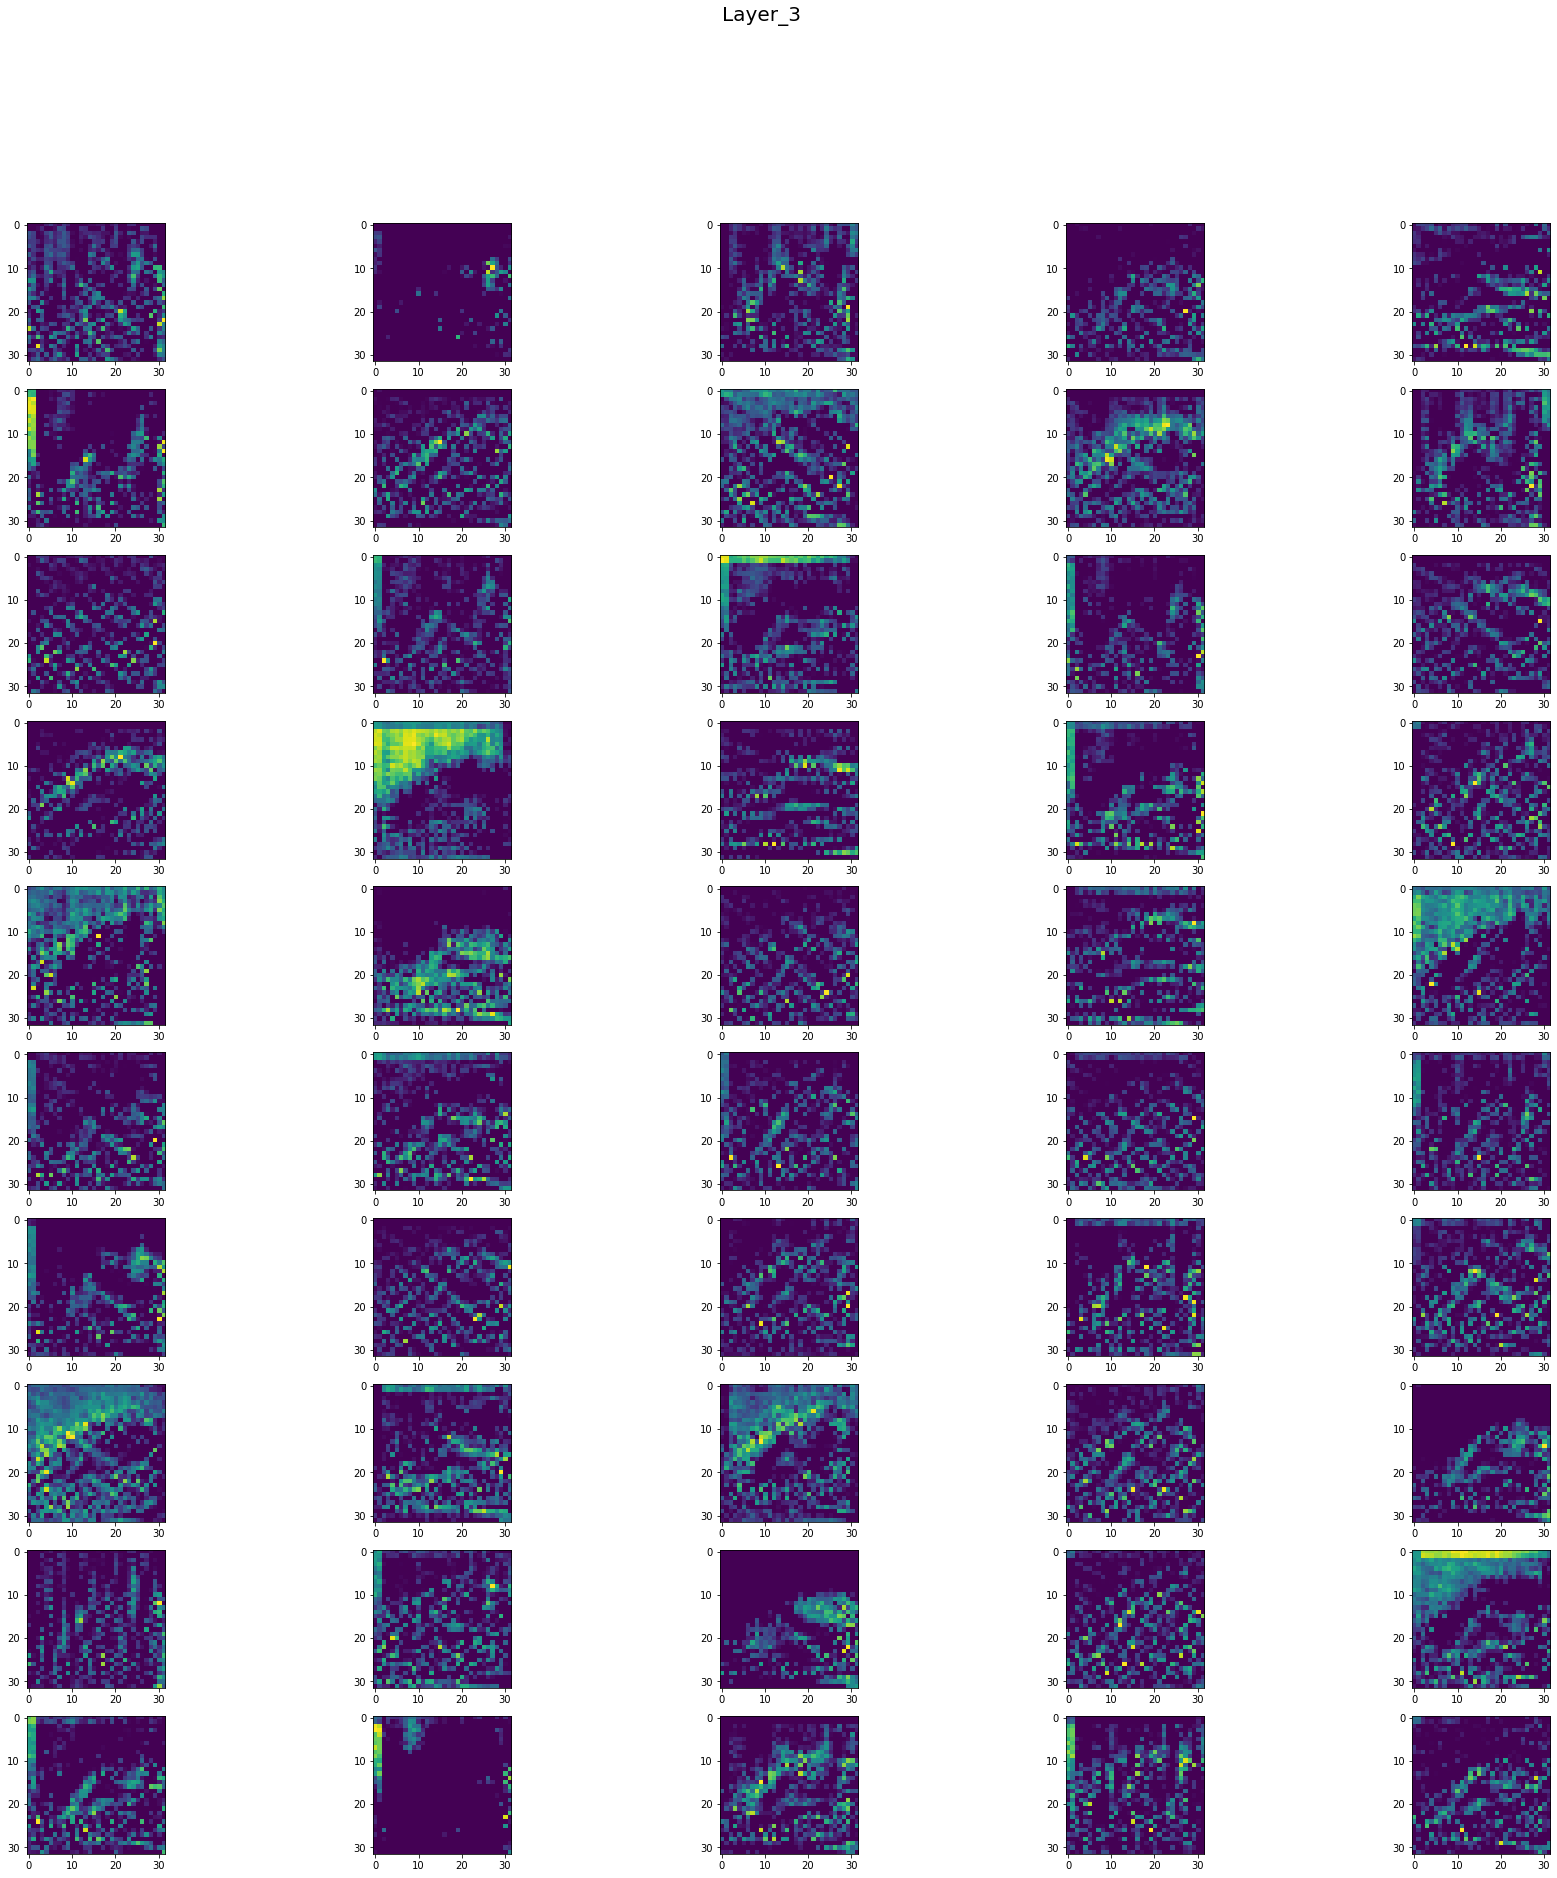

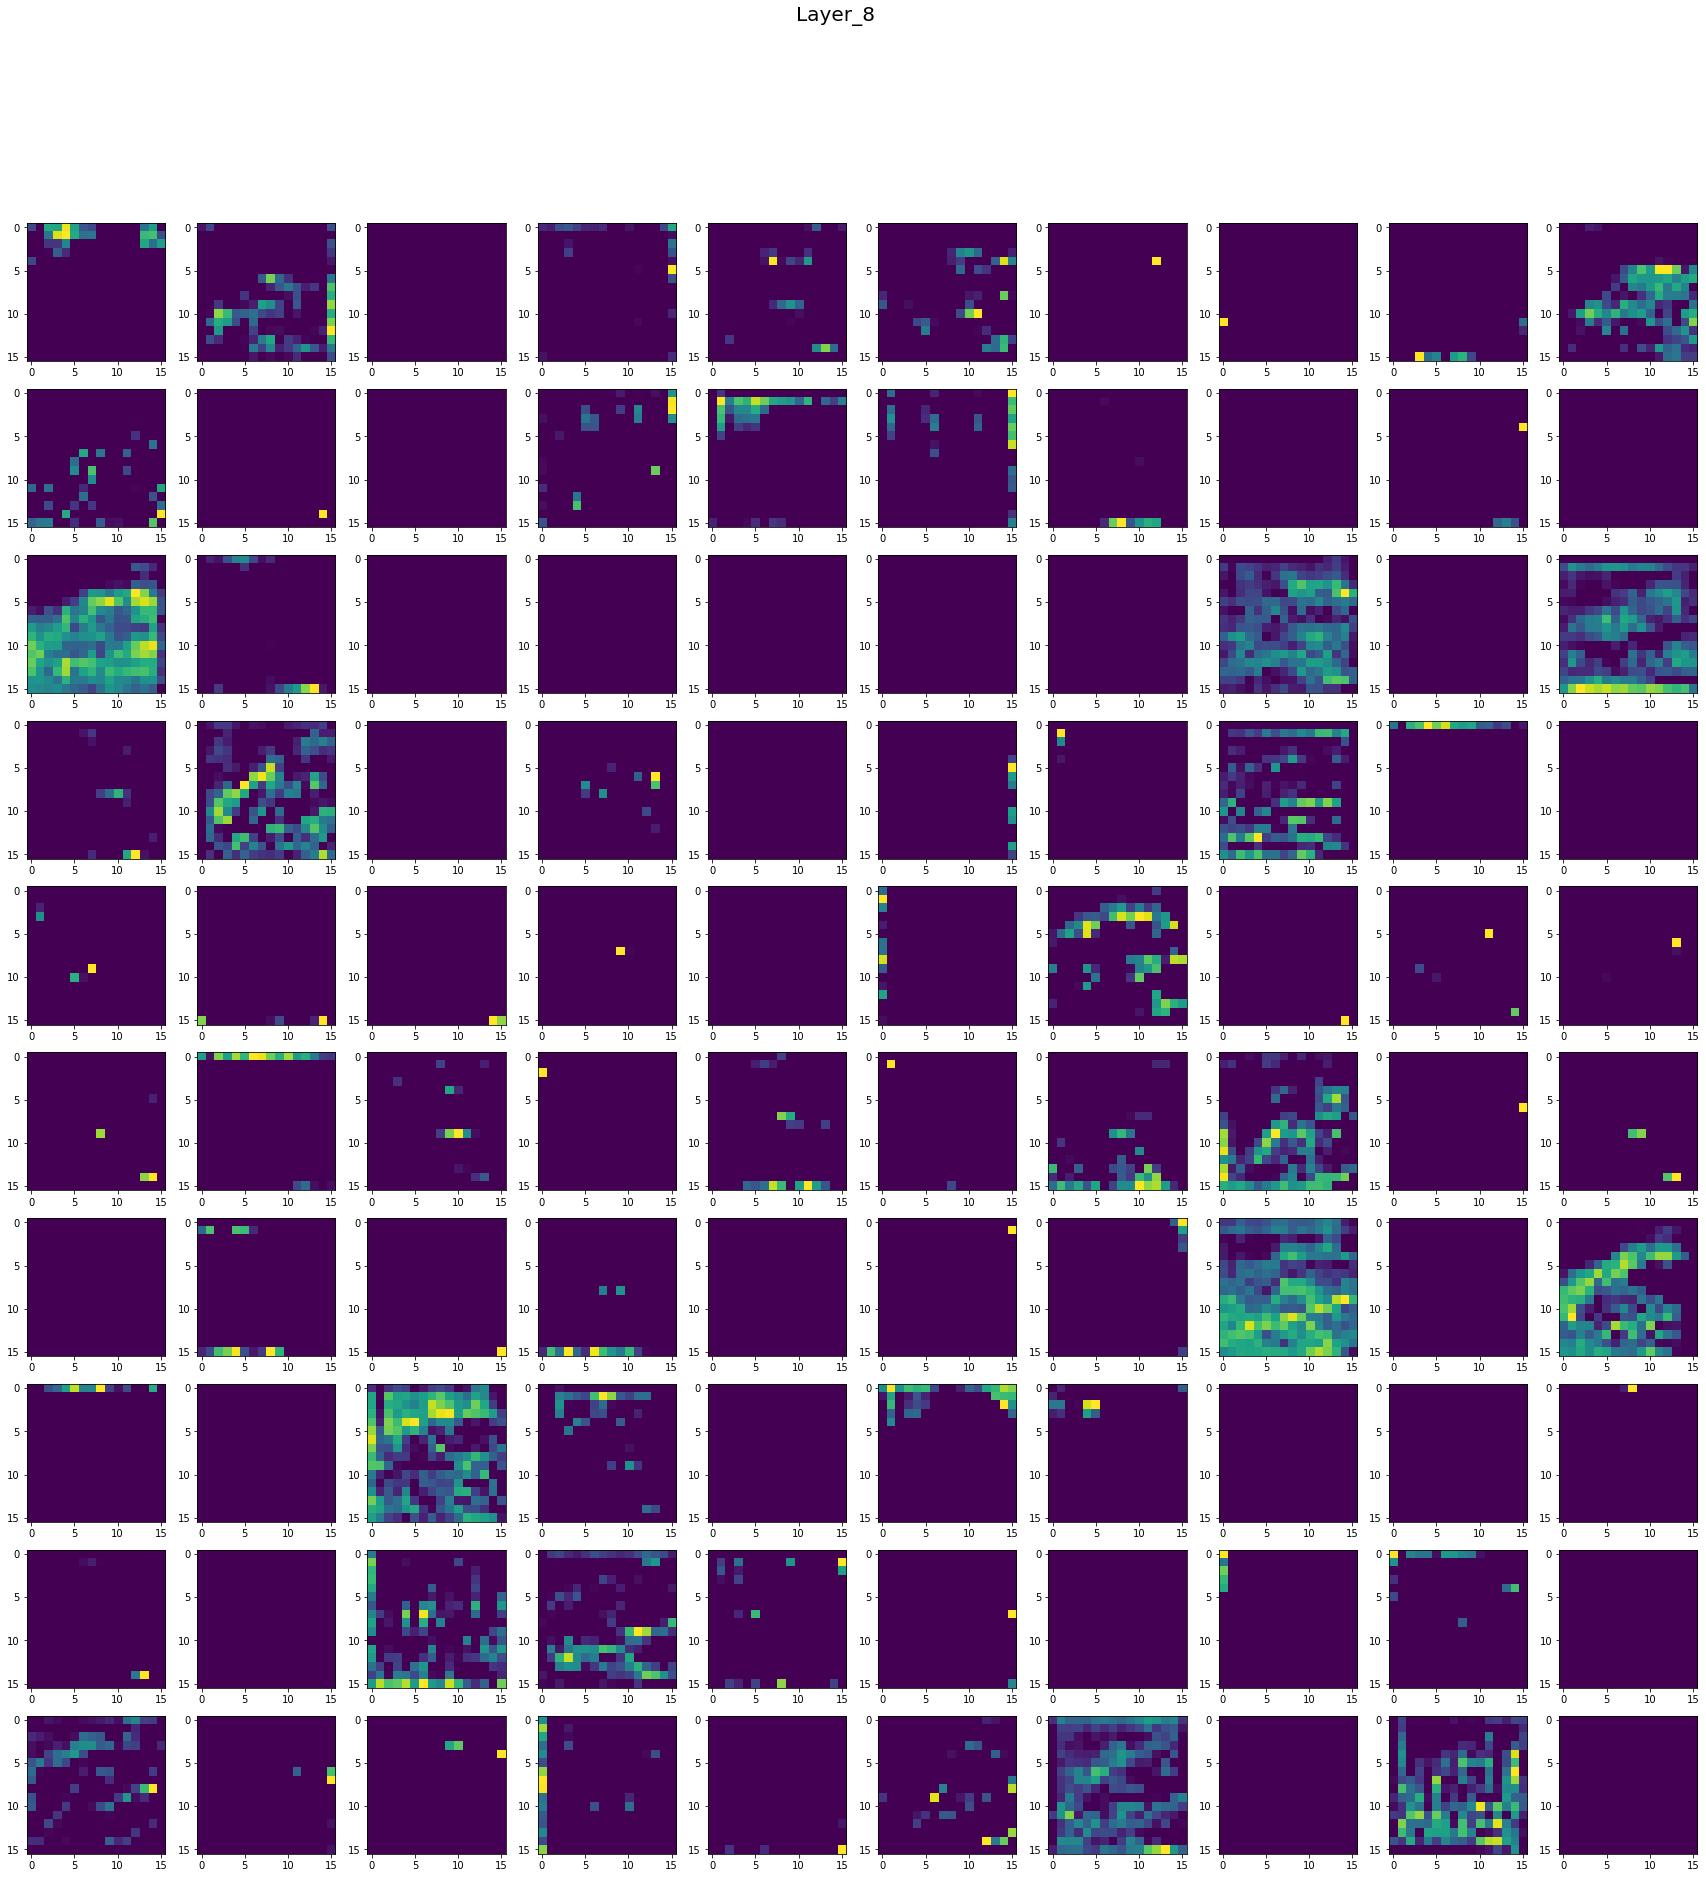

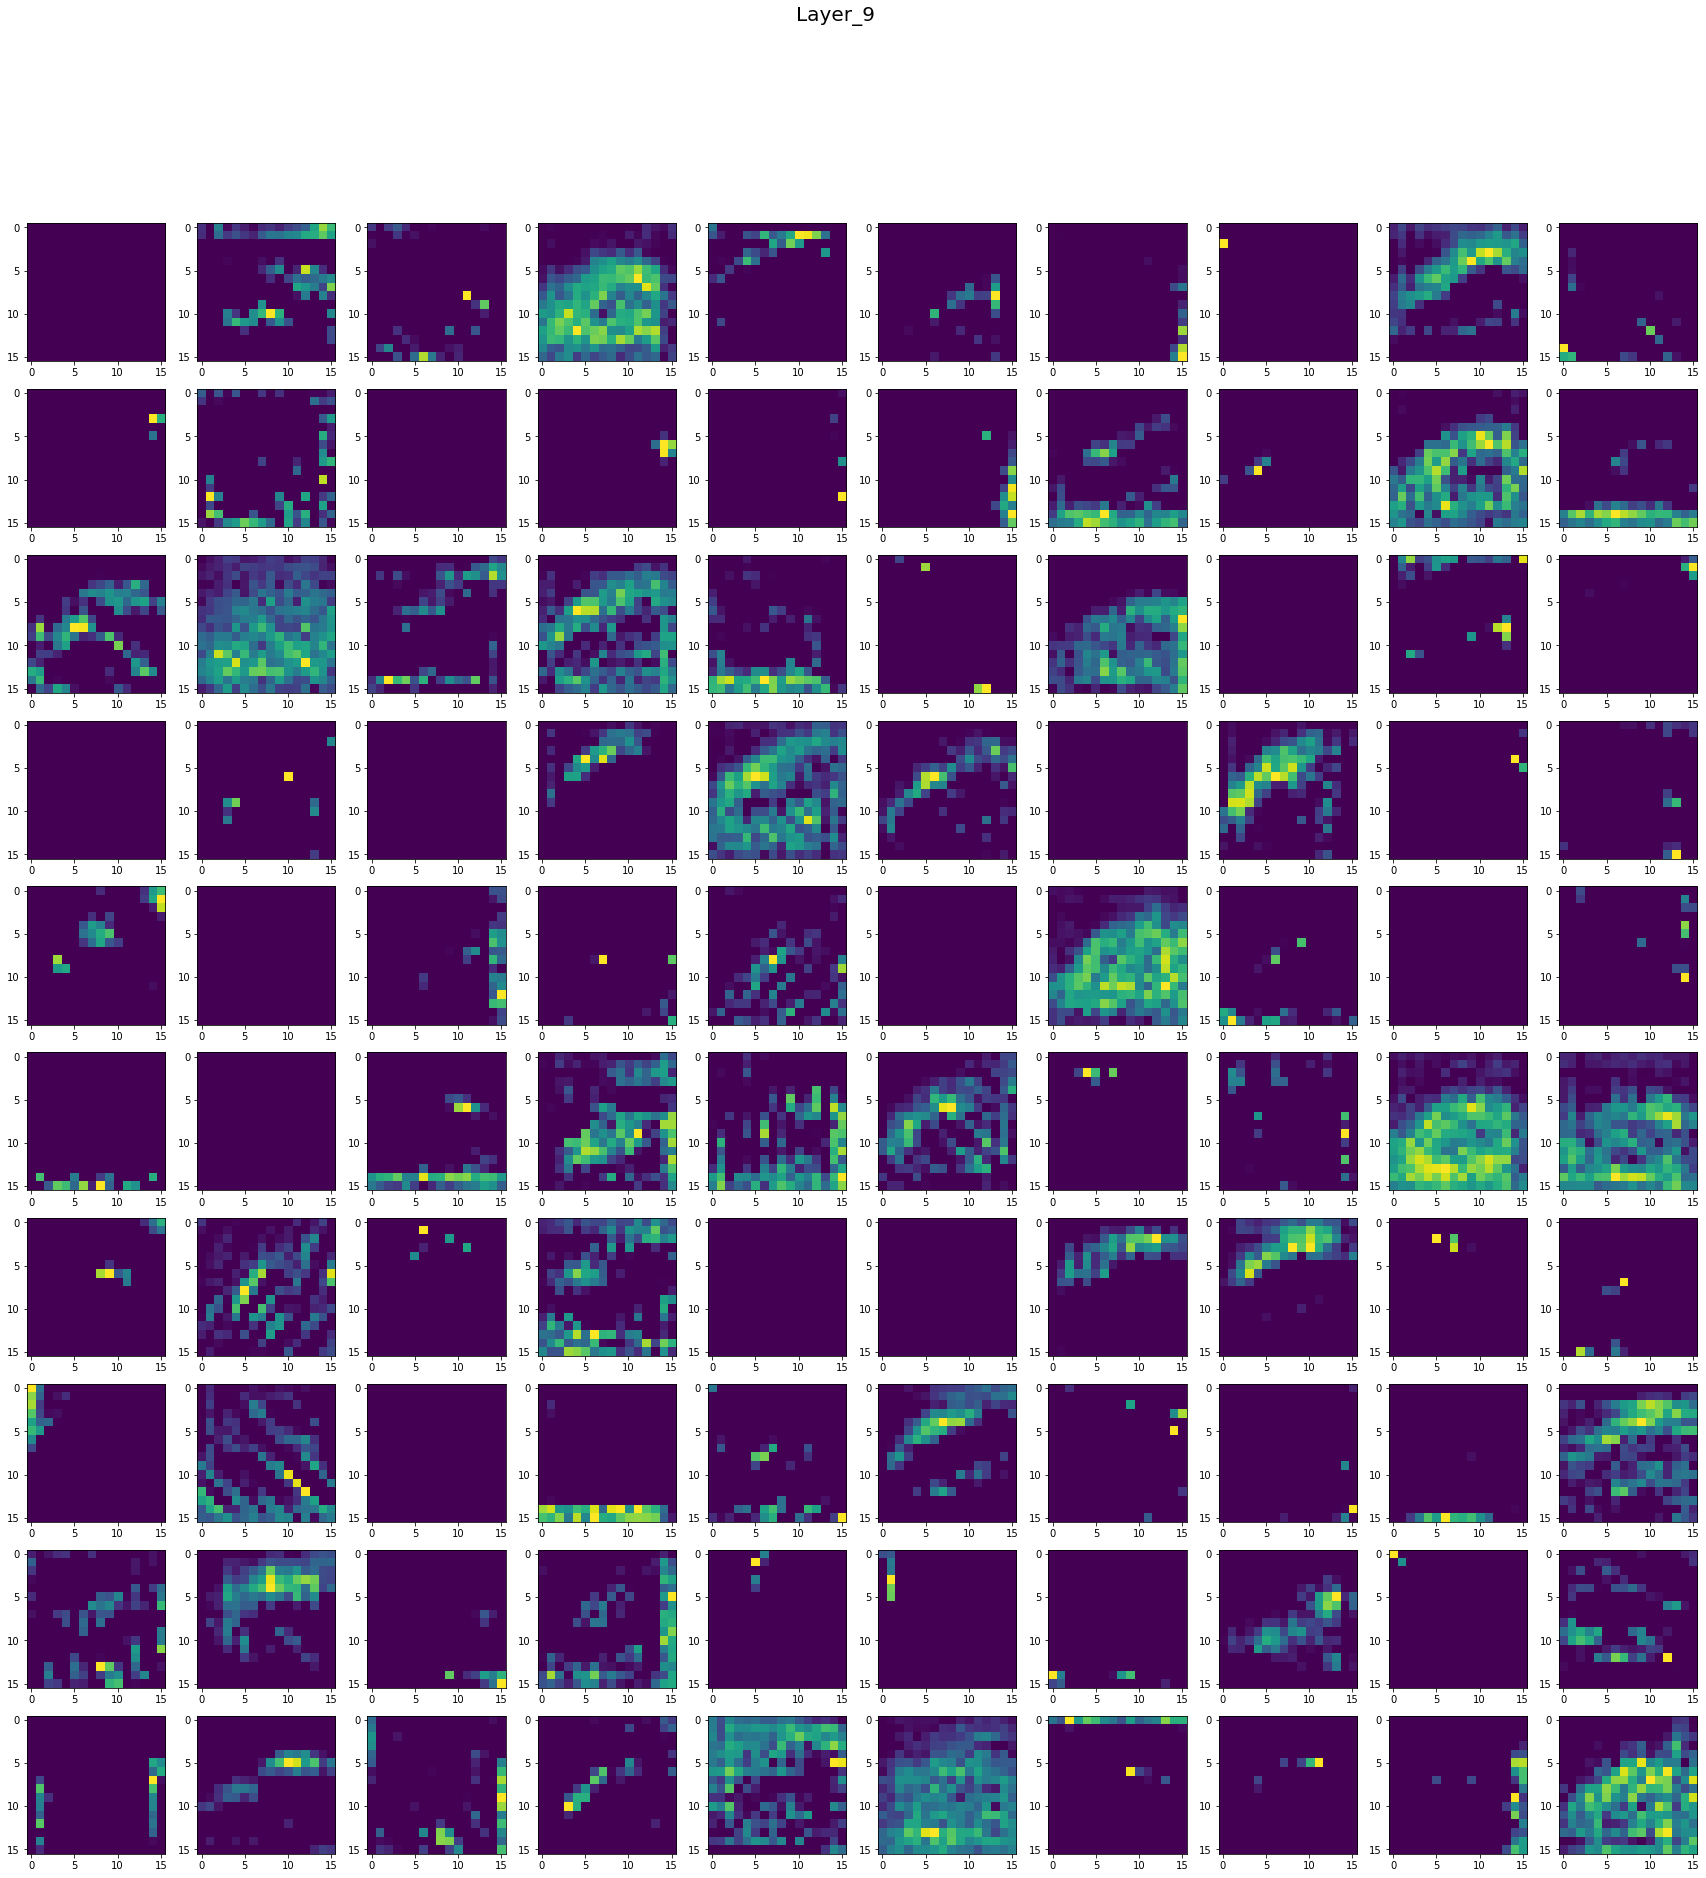

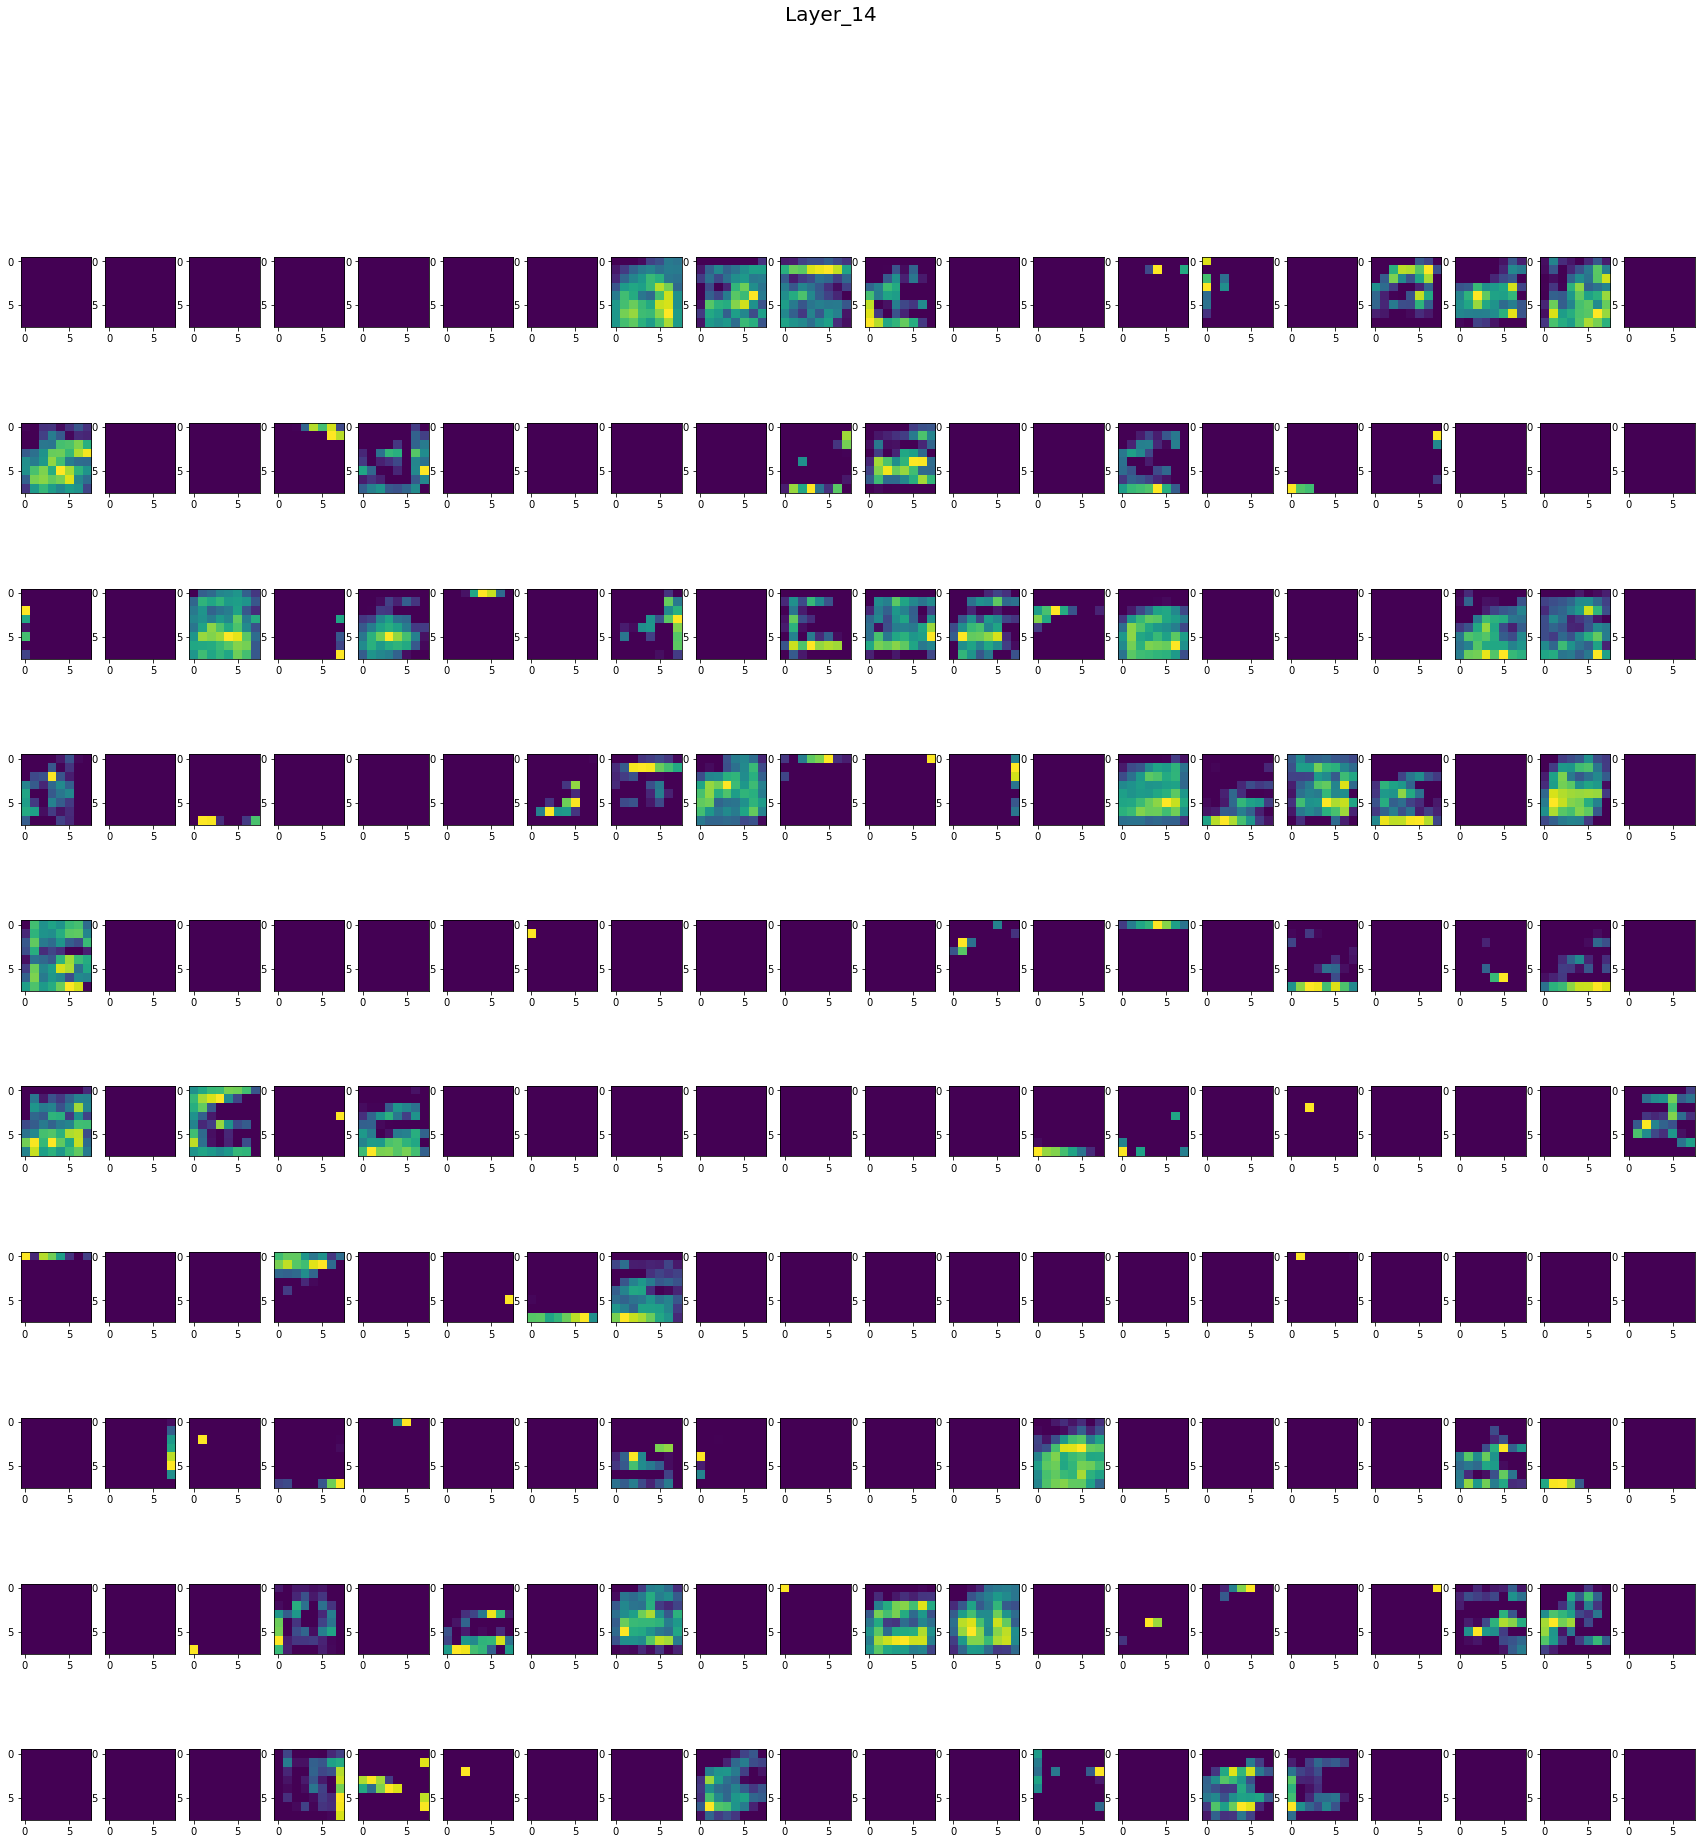

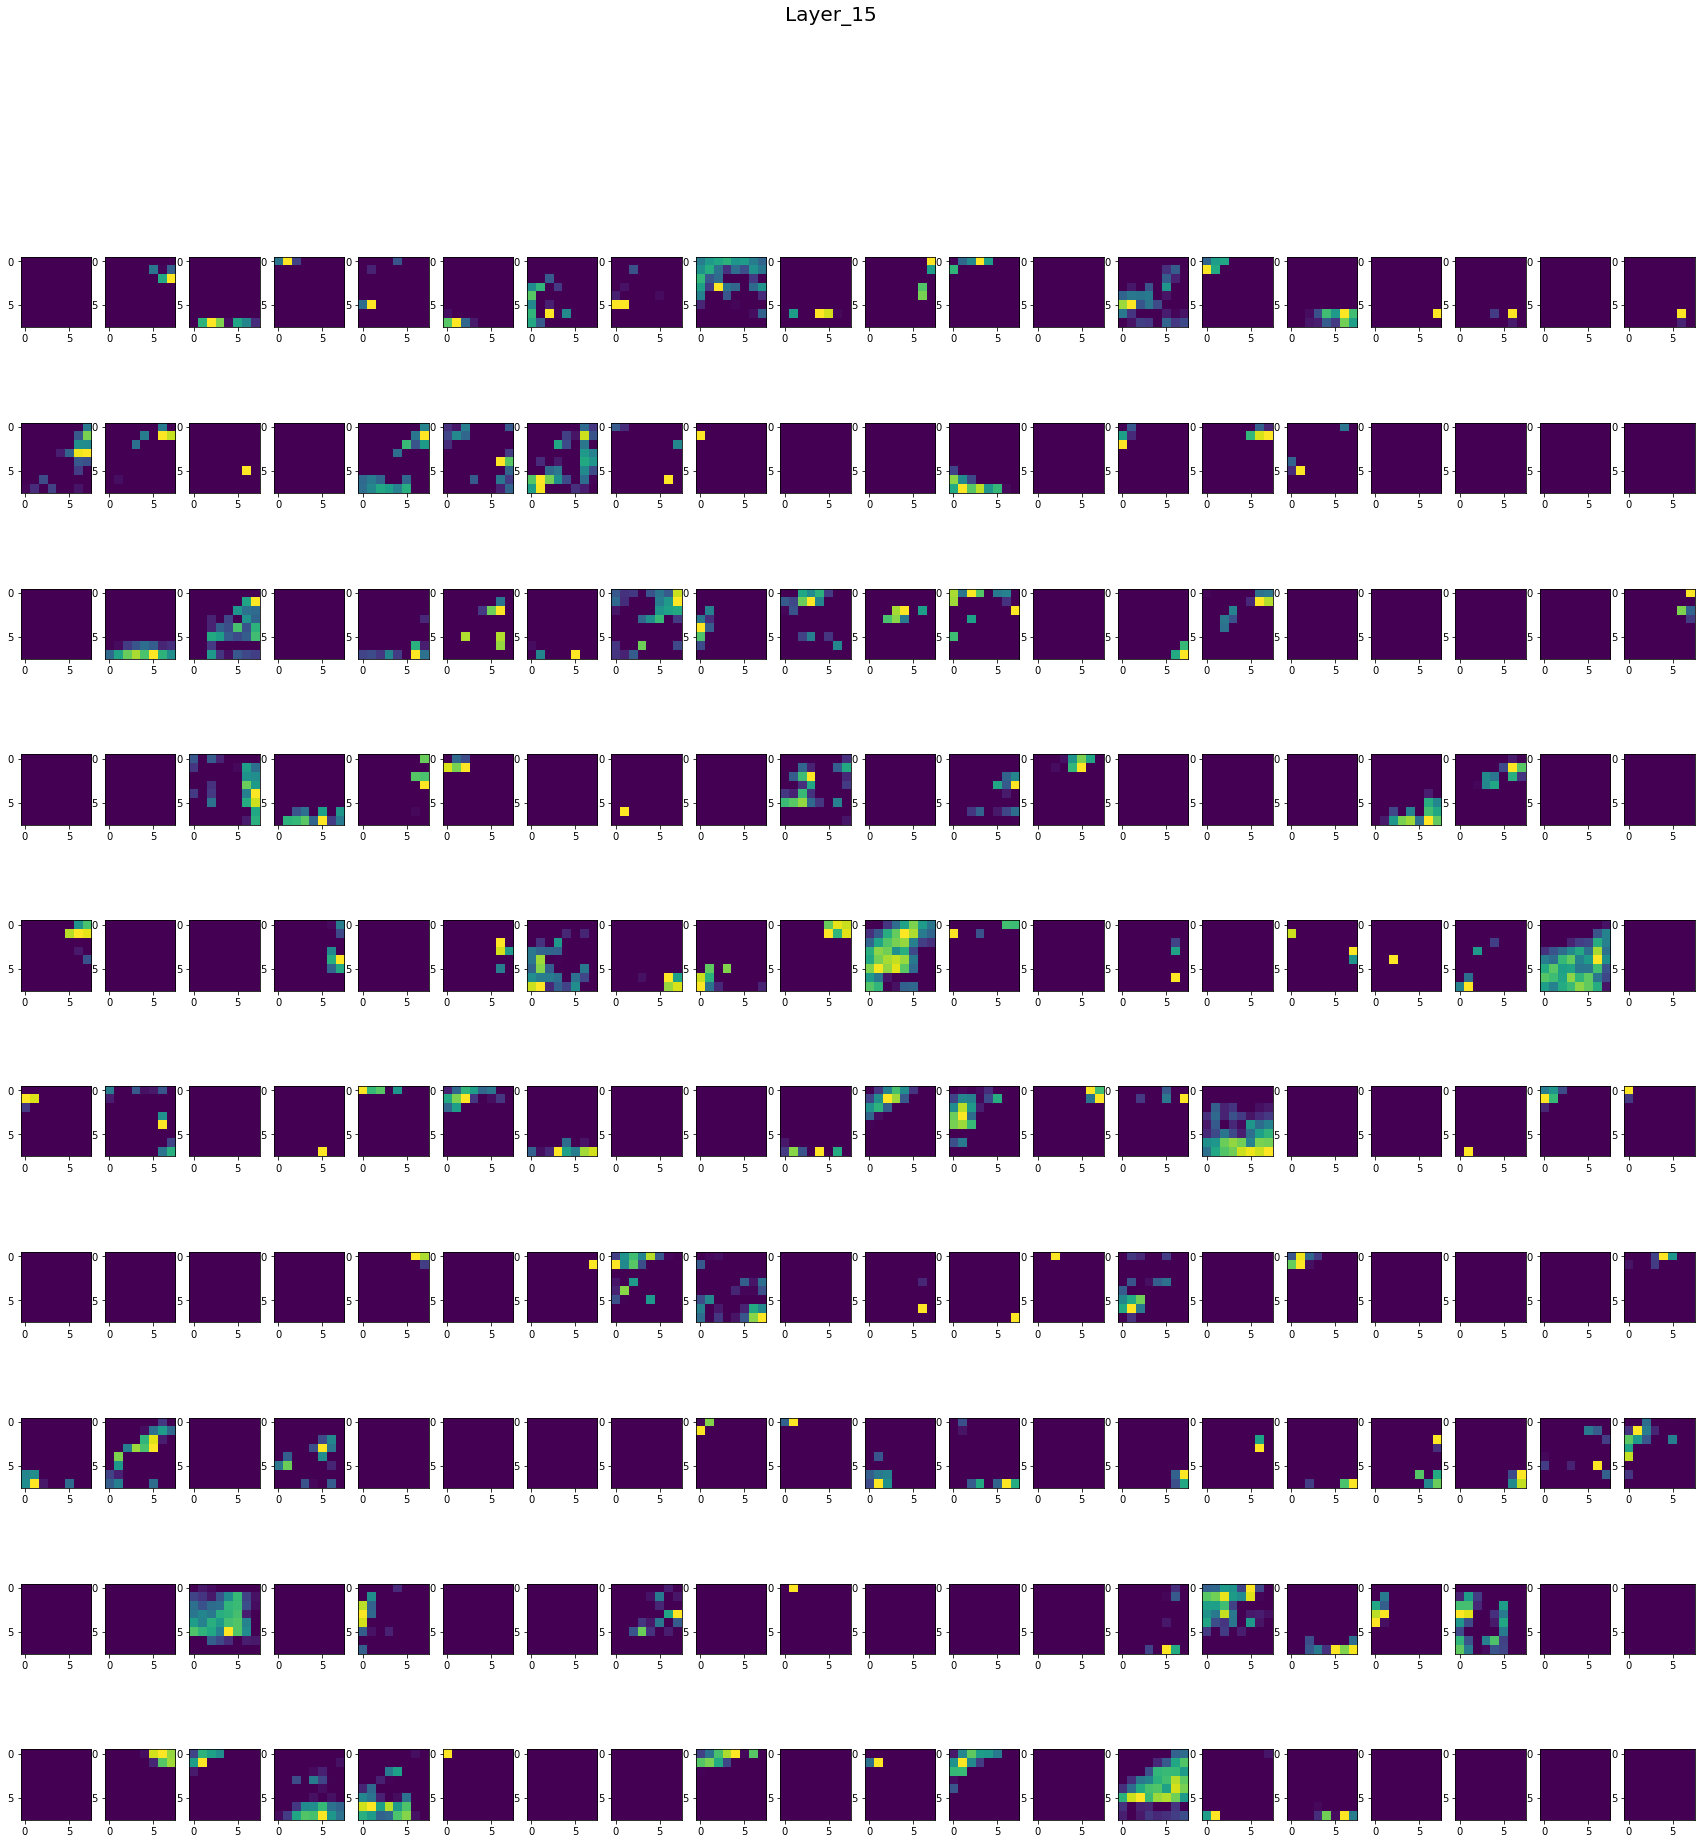

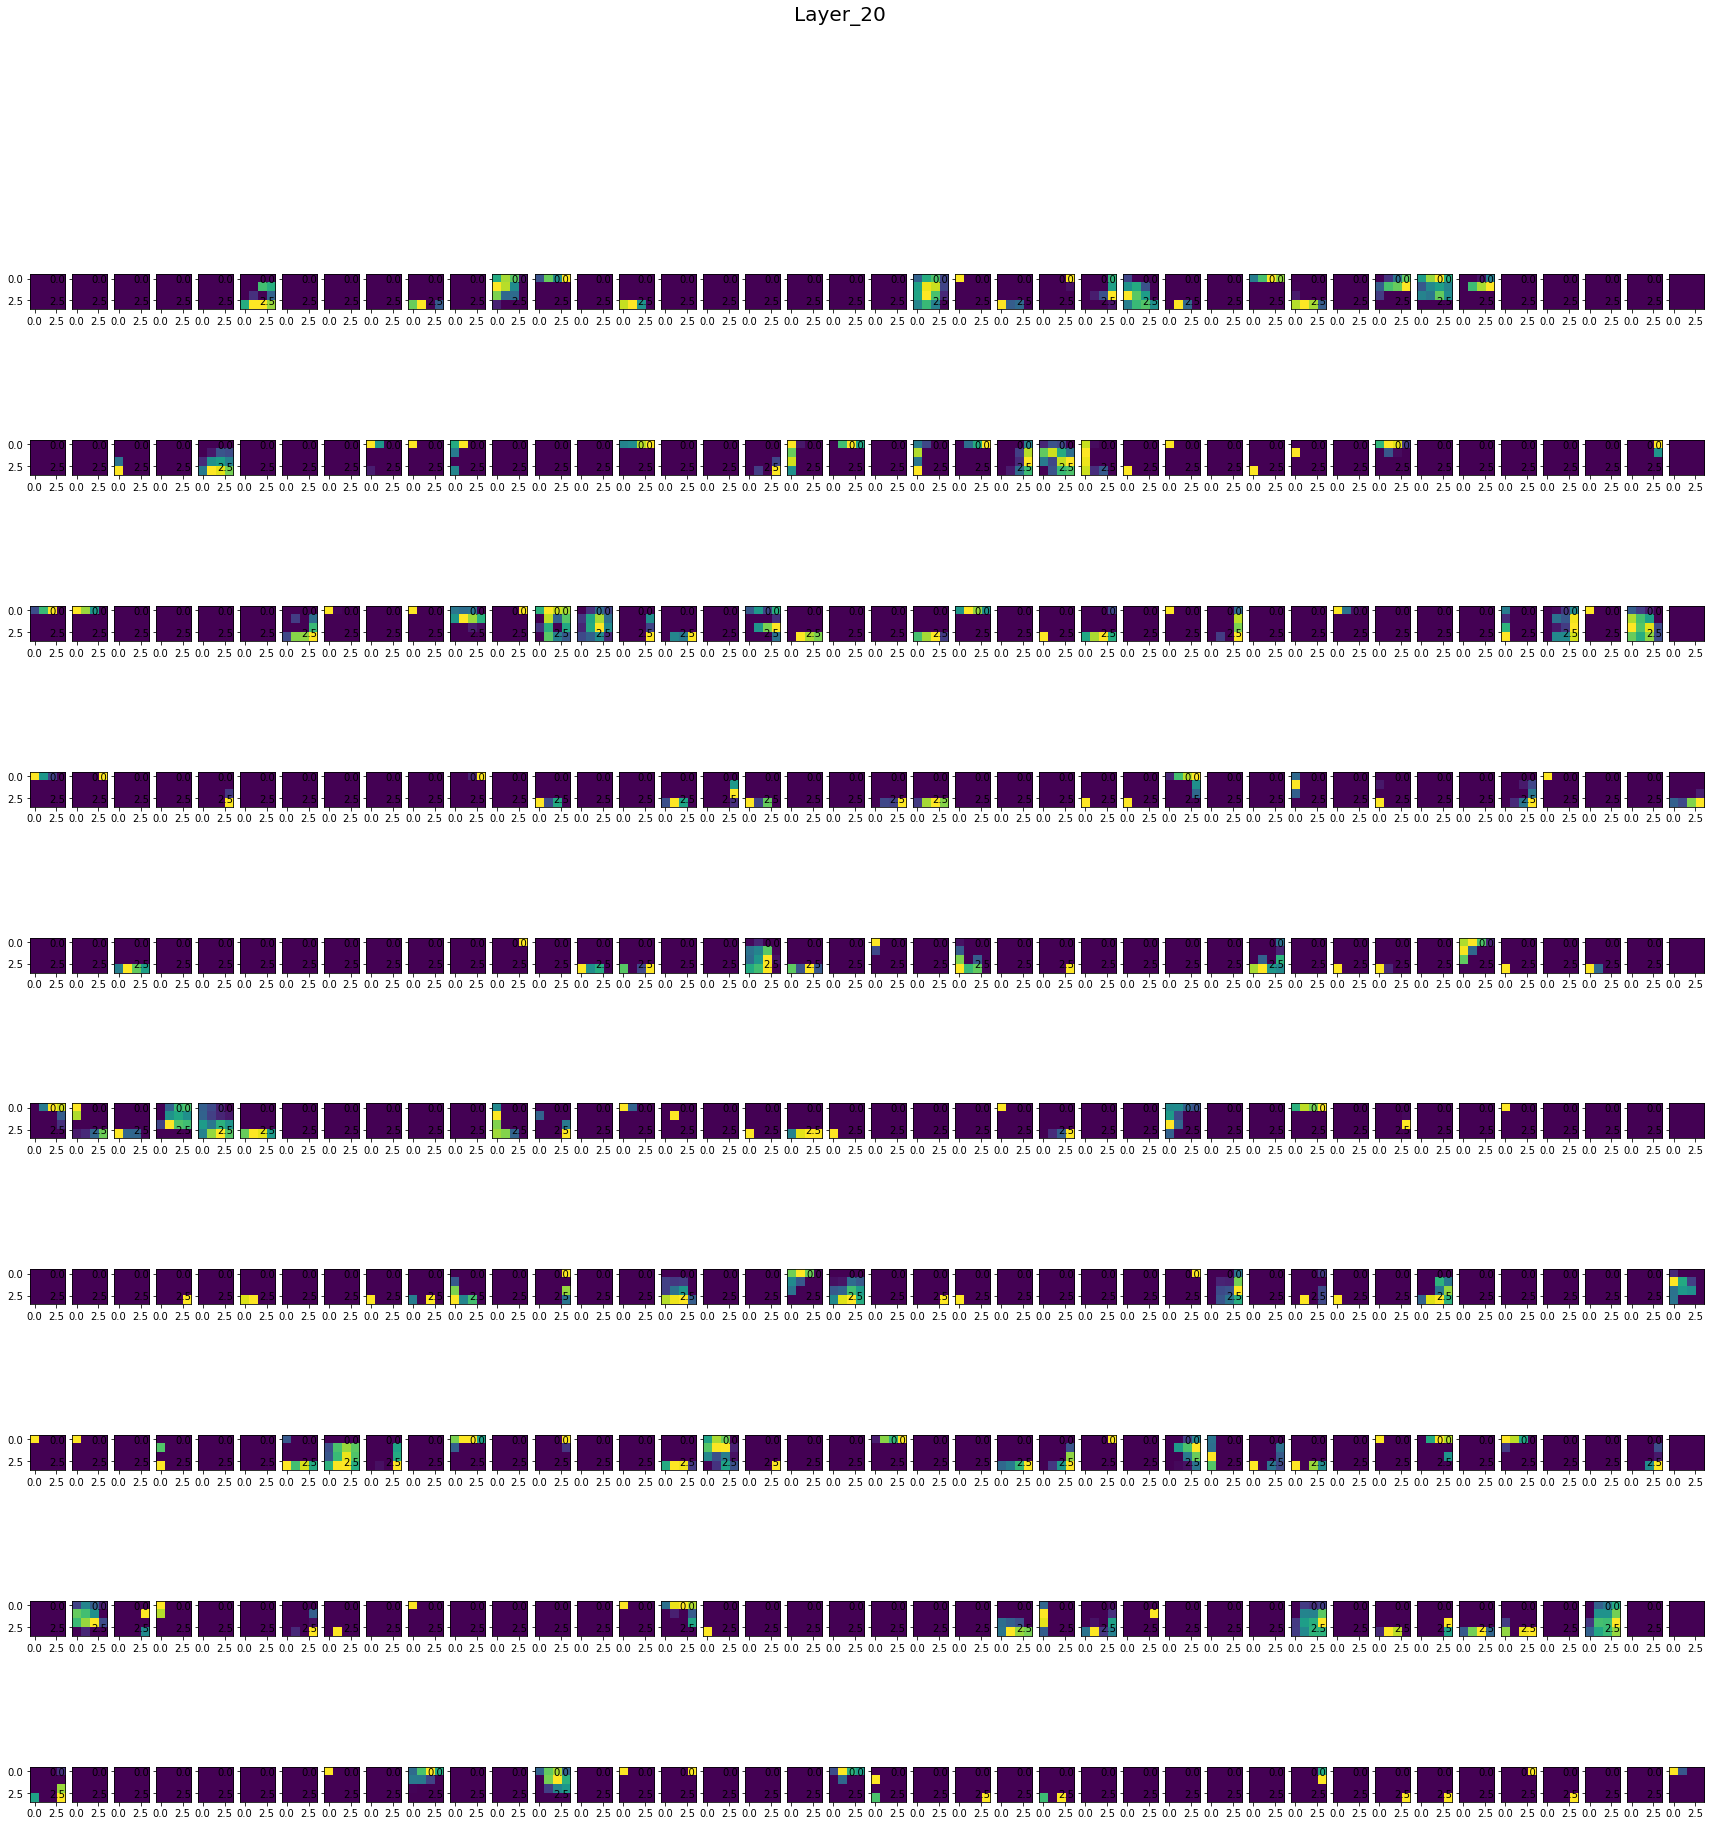

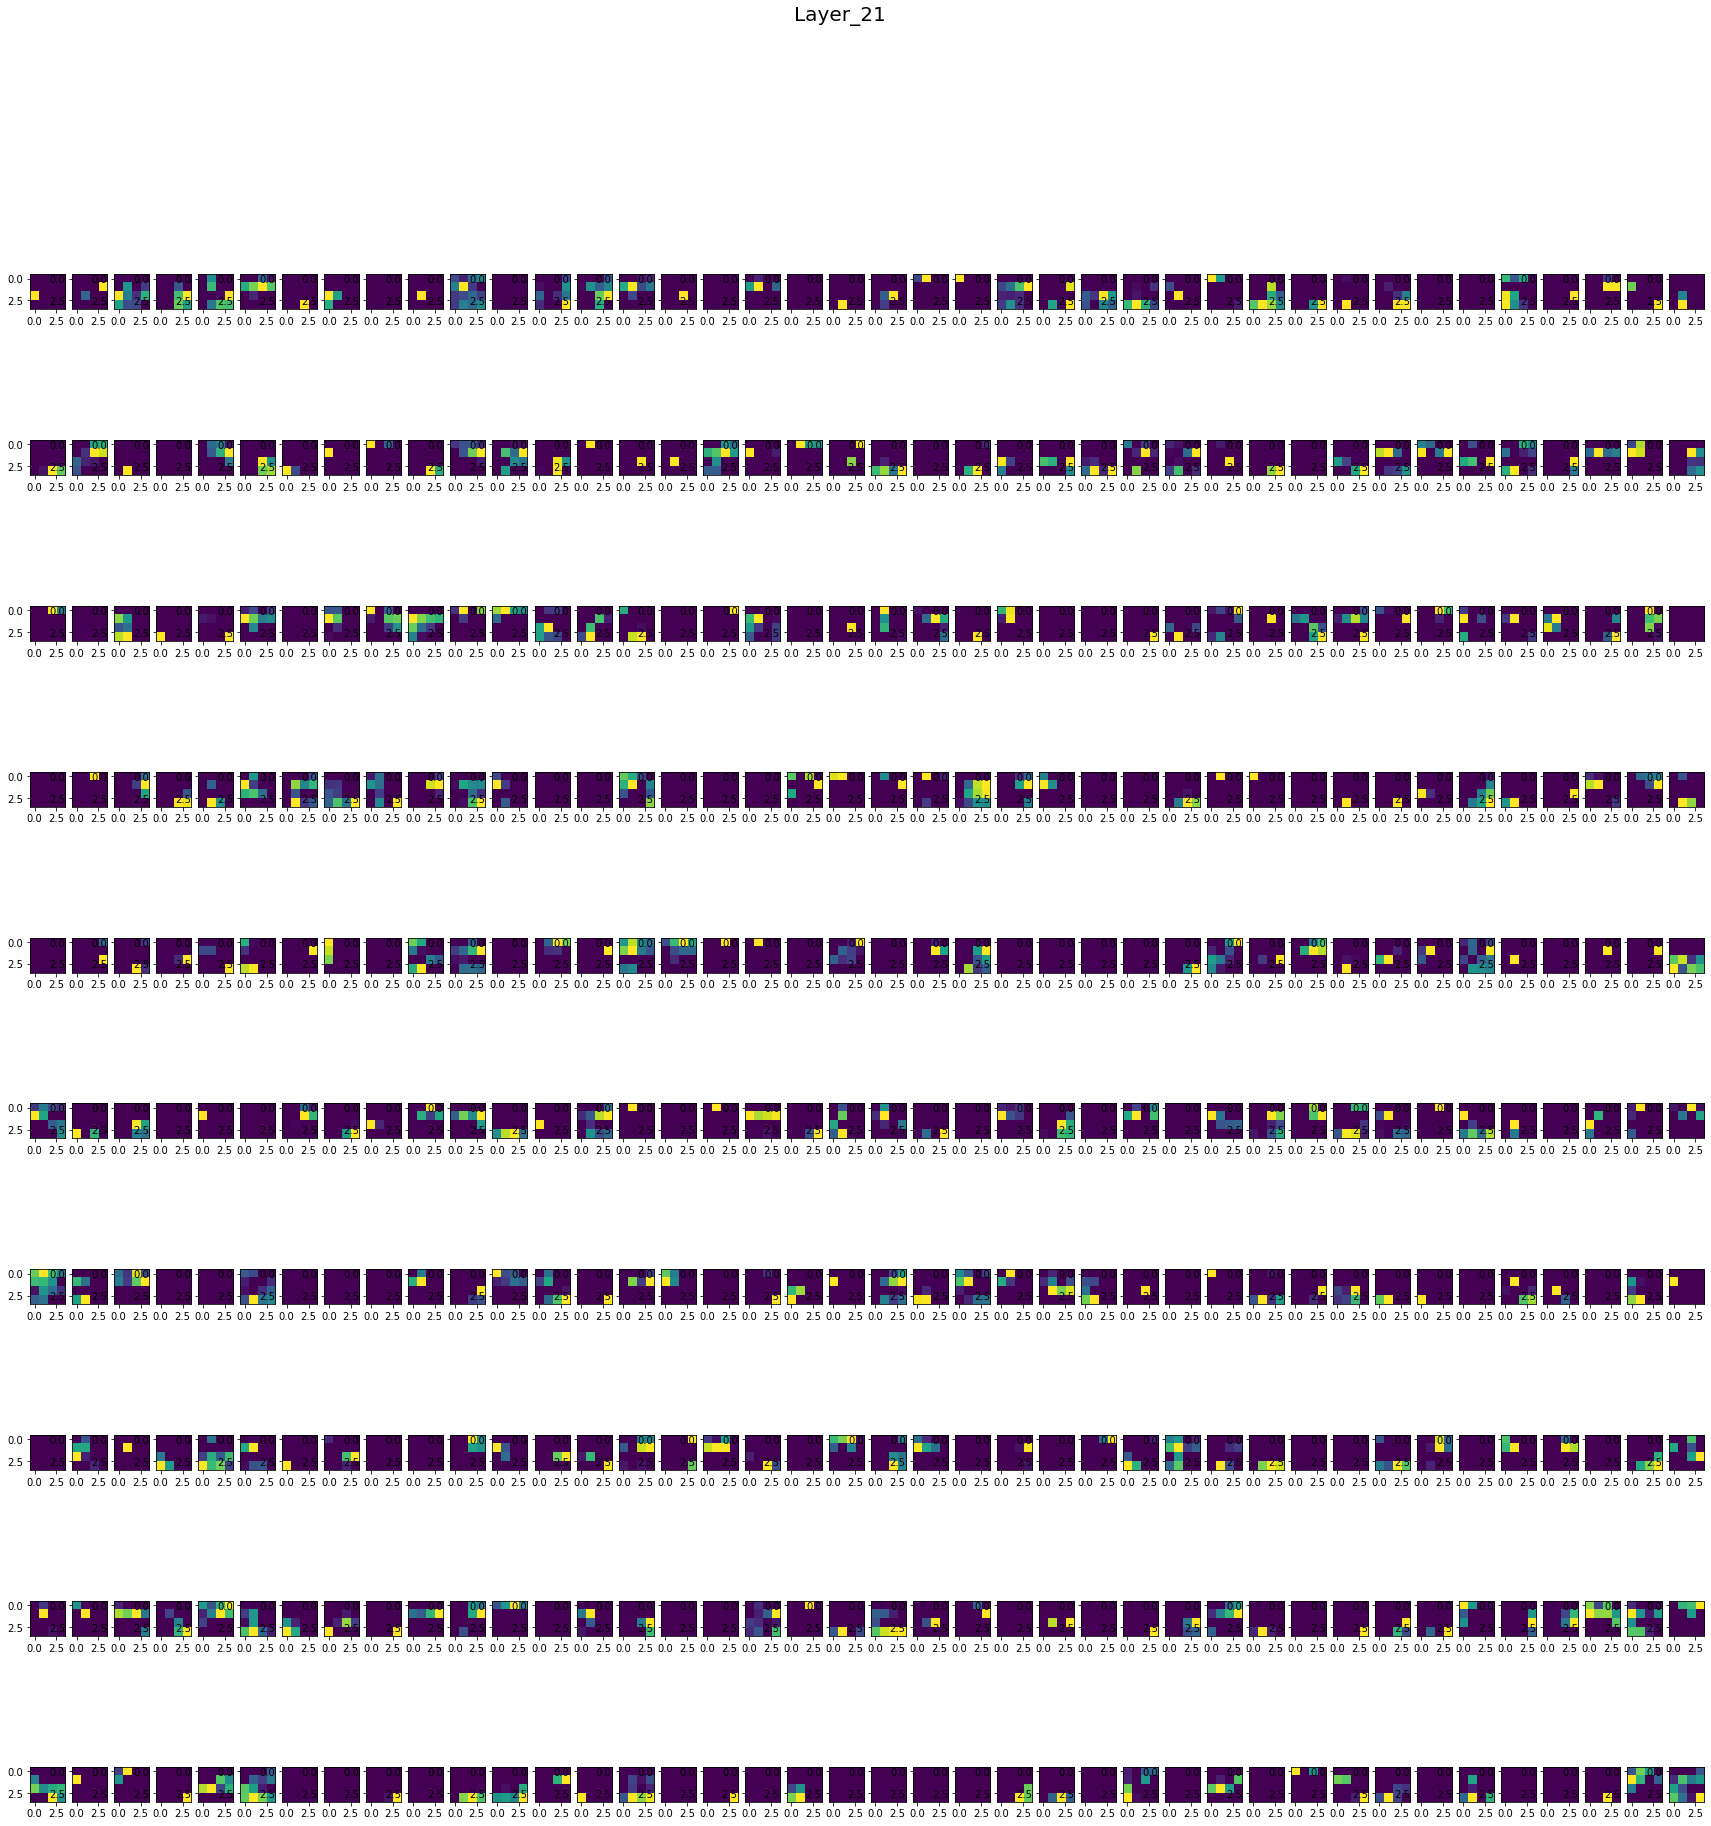

In [12]:
#Activation Maps

#Test image load
image = load_img("cat.png" , target_size=(32,32,3))
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

#Generate Feature Maps
blocks = [ 2, 3 , 8 , 9 , 14, 15, 20, 21]
outputs = [model.layers[i].output for i in blocks]
feature_map_model = Model( inputs= model.inputs, outputs = outputs)
feature_maps = feature_map_model.predict([image,image])


#Plot feature maps
for i,fmap in zip(blocks,feature_maps):
    fig = plt.figure(figsize=(30,30))
    grid = int(fmap.shape[3]/10)
    #https://stackoverflow.com/a/12444777
    fig.suptitle("Layer_{}".format(i) , fontsize=20)
    for i in range(1,fmap.shape[3]+1):

        plt.subplot(10,grid,i)
        plt.imshow(fmap[0,:,:,i-1])
    
plt.show()
